<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/03_Computer_Vision_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fastai2 Image Data Augmentation

[Data Augmentation in Computer Vision
](https://dev.fast.ai/vision.augment)

In this tutorial we will see how to do computer vision data augmentation with fastai2. Also, take a look at the fastai2 datablock api.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Run once per session in a quiet mode -- less output
!pip install fastai2 -q
!pip install nbdev -q
!pip install utils -q

     |████████████████████████████████| 194kB 3.5MB/s 
     |████████████████████████████████| 51kB 1.9MB/s 


In [3]:
from utils import *
from fastai2.imports import *
from fastai2.vision.widgets import *
from fastai2.vision.all import *
from nbdev.showdoc import *

## Create a directory and upload images

In [4]:
path = Path('images/')
path.mkdir(parents=True, exist_ok=True)

In [5]:
path

Path('images')

# An image 
[numeric representation](https://computersciencewiki.org/index.php/File:8-gif.gif)

# Acquiring an image.
Using PIL Python Imaging Library.

In [6]:
# acquiring an image and getting its shape
img = PILImage(PILImage.create("/content/images/puppy1.jpeg"))
img.shape

(168, 299)

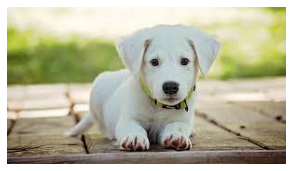

In [7]:
# showing the image
show_image(img)

### Resizing the image

In [8]:
# resizing an image and showing its shape
img = PILImage(PILImage.create("/content/images/puppy1.jpeg").resize((50,50))) #width and height
img.shape

(50, 50)

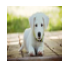

In [9]:
show_image(img)

# Flipping an image.
`img.flip_lr()`

In [10]:
# acquiring an image and resizing it 
img = PILImage(PILImage.create("/content/images/puppy1.jpeg").resize((600,400))) #width and height
img.shape

(400, 600)

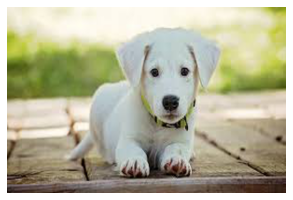

In [11]:
show_image(img)

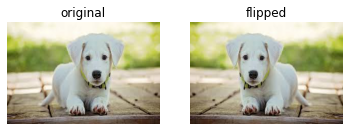

In [12]:
# plotting the images - original and image flipped
_,axs = subplots(1,2)
show_image(img, ctx=axs[0], title='original')
show_image(img.flip_lr(), ctx=axs[1], title='flipped');

NOTE: the size has been reduced by 432x216 px. The picture has been flipped left/right.

### Random flip with a probability of `p`

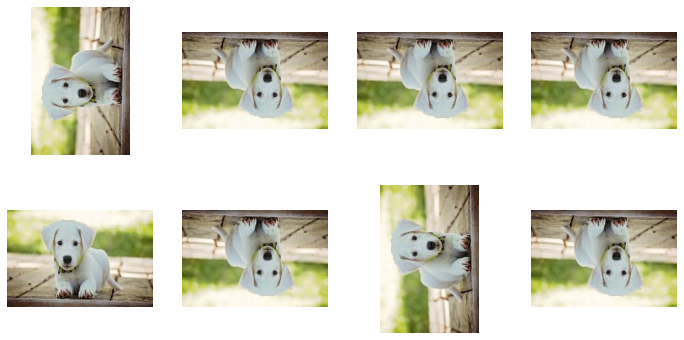

In [15]:
# random flip with a probability of p
_,axs = subplots(2, 4)
for ax in axs.flatten():
    show_image(DihedralItem(p=1.0)(img, split_idx=0), ctx=ax)

NOTE:  Taking an image and plotting it on 2 rows and 4 columns.
- `axs.flatten()` Return a copy of the array collapsed into one dimension. 
- `show_img` shows a PIL or a Pytorch image on an `ax`.
- `dihedral` Randomly flip `x` image based on a probability of `p`.
- `split_idx=0` A RandTransform is only applied to the training set by default, so you have to pass split_idx=0, if you are calling it directly and not through a Datasets. That behavior can be changed by setting the attr split_idx of the transform to None.

In [25]:
# Show a PIL or PyTorch image on `ax`.
??show_image

## Cropping


### Center crop or pad an image to size.
`img.crop_pad(sz)`

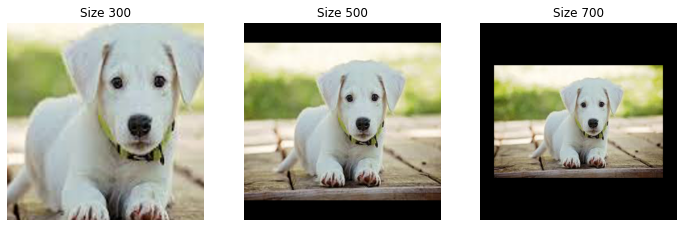

In [16]:
# center cropping and padding an image to size
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,sz in zip(axs.flatten(), [300, 500, 700]):
    show_image(img.crop_pad(sz), ctx=ax, title=f'Size {sz}');

# Padding
`PadMode`

Illustrating 3 padding modes :
- none (zeros)
- border
- reflection

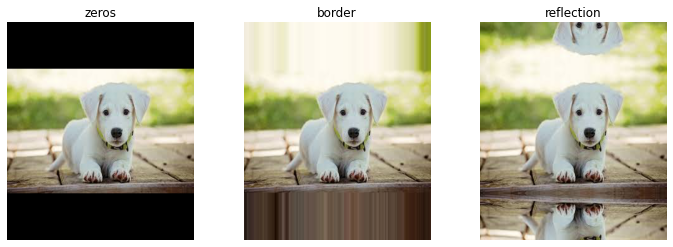

In [17]:
# padding: none, border, reflection
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,mode in zip(axs.flatten(), [PadMode.Zeros, PadMode.Border, PadMode.Reflection]):
    show_image(img.crop_pad((600,700), pad_mode=mode), ctx=ax, title=mode);


# Resizing
By default resize **'squishes'** the image to the size specified. The image is resized so that the shorter dimension matches the size specified and the rest padded with what is specified in pad_mode.

The images are resized/resampled using bilinear and nearest neighbour interprolations.

In [18]:
img.shape, type(img)

((400, 600), fastai2.vision.core.PILImage)

## Resizing and cropping

When doing the resize, we use resamples[0] for images and resamples[1] for segmentation masks.

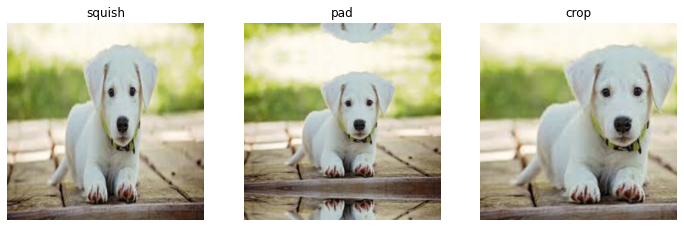

In [19]:
# resizing an image to 256 px - methods: squish, pad, crop
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, split_idx=0), ctx=ax, title=method);

On the validation set, the crop is always a center crop (on the dimension that's cropped).


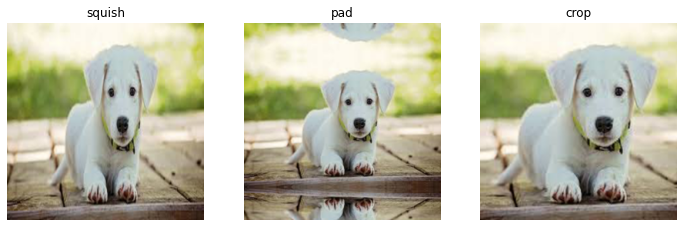

In [20]:
# on the validation set [split_idx=1], the crop is always center.
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, split_idx=1), ctx=ax, title=method);

Picks a random scaled crop of an image and resize it to size

The crop picked as a random scale in range (min_scale,1) and ratio in the range passed, then the resize is done with resamples[0] for images and resamples[1] for segmentation masks. On the validation set, we center crop the image if it's ratio isn't in the range (to the minmum or maximum value) then resize.

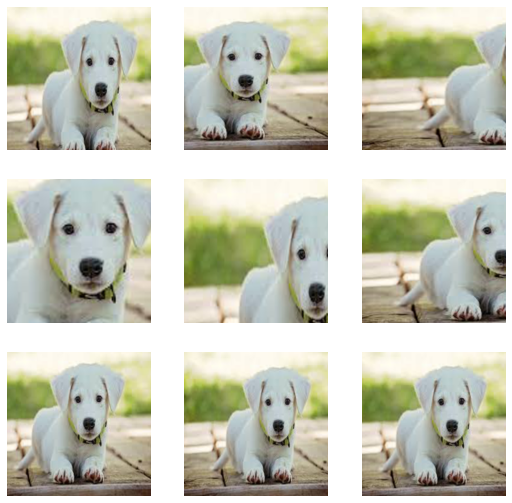

In [21]:
# random resize and crop of an image
crop = RandomResizedCrop(256)
_,axs = plt.subplots(3,3,figsize=(9,9))
for ax in axs.flatten():
    cropped = crop(img)
    show_image(cropped, ctx=ax);


Squish is used on the validation set, removing val_xtra proportion of each side first.

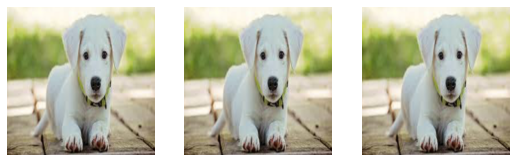

In [22]:
# squishing an image on the validation set
_,axs = subplots(1,3)
for ax in axs.flatten(): show_image(crop(img, split_idx=1), ctx=ax);


In [64]:
test_eq(cropped.shape, [256,256])

Resizes the biggest dimension of an image to max_sz maintaining the aspect ratio

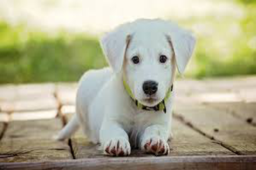

In [23]:
# ratio resize
RatioResize(256)(img)

# Batch Transformation using GPU
Affine transformations are done on the GPU. That is going through a batch and getting a tensor image.

In [27]:
# defining a tensor image
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
# defining a batch
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

Picks a random scaled crop of an image and resize it to size. Tensor images representation are stored in float. Tensor permut is used to swap the axes. 

## Random Resize Crop - GPU
`RandomResizedCropGPU(224, p=1.)`

Picks a random scaled crop of an image and resize it to size.


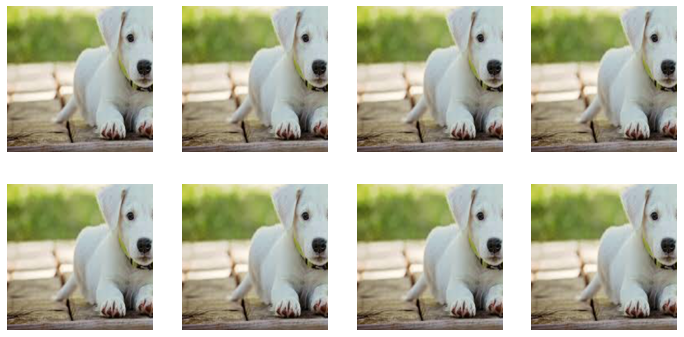

In [28]:
# randon resize crop on a GPU
# batch size = 8 images
t = _batch_ex(8) 
# Resizing using the GPU
rrc = RandomResizedCropGPU(224, p=1.)
y = rrc(t)
# plotting the batch images
_,axs = plt.subplots(2,4, figsize=(12,6))
for i, ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax)

NOTE: 8 occurences of the same image resized to 224 px.

## Returning a random flip matrix
`DeterministicFlip()`
Flip the batch every other call

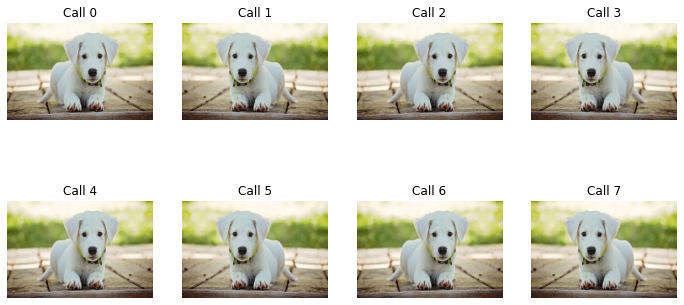

In [29]:
# doing a deterministic flip
t = _batch_ex(8)
dih = DeterministicFlip()
_,axs = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y = dih(t)
    show_image(y[i], ctx=ax, title=f'Call {i}')

NOTE: making 8 calls (from 0 to 7) to flip an image every other call

## Flipping - Applying a random dihedral transformation
`Dihedral()`

Apply a random dihedral transformation to a batch of images with a probability of `p`

`draw` can be specified if you want to customize which flip is picked when the transform is applied (default is a random number between 0 and 7). It can be an integer between 0 and 7, a list of such integers (which then should have a length equal to the size of the batch) or a callable that returns an integer between 0 and 7.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


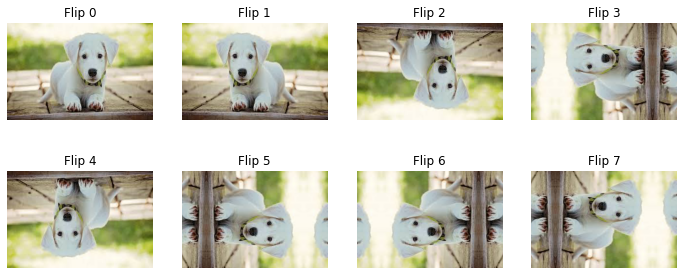

In [30]:
# applying a random dihedral transformation
t = _batch_ex(8)
dih = Dihedral(p=1., draw=list(range(8)))
y = dih(t)
y = t.dihedral_batch(p=1., draw=list(range(8)))
_,axs = plt.subplots(2,4, figsize=(12,5))
for i,ax in enumerate(axs.flatten()): 
  show_image(y[i], ctx=ax, title=f'Flip {i}')

## Rotation
`rotate`

Apply a random rotation of at most max_deg with probability p to a batch of images

`draw` can be specified if you want to customize which angle is picked when the transform is applied (default is a random float between `-max_deg` and `max_deg`). It can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


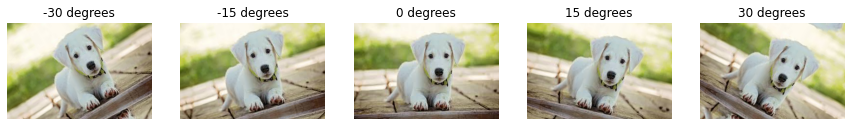

In [31]:
# image rotation with a max_deg (thetas)
thetas = [-30,-15,0,15,30]
y = _batch_ex(5).rotate(draw=thetas, p=1.)
_,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'{thetas[i]} degrees')


NOTE: `draw=thetas`, `thetas` is a list containing the following values: `[-30, -15, 0, 15, 30]`

## Random Zoom with different scales

Apply a random zoom of at most max_zoom with probability p to a batch of images

draw, draw_x and draw_y can be specified if you want to customize which scale and center are picked when the transform is applied (default is a random float between 1 and max_zoom for the first, between 0 and 1 for the last two). Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callbale that returns a float.

draw_x and draw_y are expected to be the position of the center in pct, 0 meaning the most left/top possible and 1 meaning the most right/bottom possible.


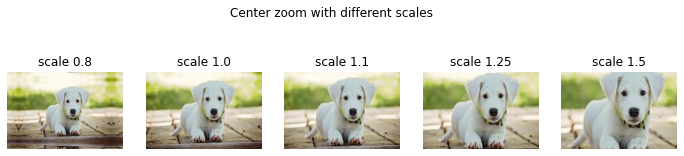

In [32]:
# random zoom with different scales
scales = [0.8, 1., 1.1, 1.25, 1.5]
n = len(scales)
y = _batch_ex(n).zoom(draw=scales, p=1., draw_x=0.5, draw_y=0.5)
fig,axs = plt.subplots(1, n, figsize=(12,3))
fig.suptitle('Center zoom with different scales')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

NOTE: Center zoom with different scales

Constant scale and different random numbers.

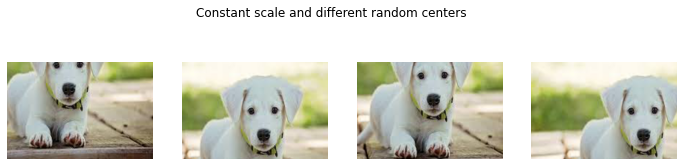

In [33]:
# constant scale and different random centers
y = _batch_ex(4).zoom(p=1., draw=1.5)
fig,axs = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Constant scale and different random centers')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax)

## Warping (distortion)
`Warp`
Doing vertical and horizontal warping.

Image warping is the process of digitally manipulating an image such that any shapes portrayed in the image have been significantly distorted.

Apply perspective warping with magnitude and p on a batch of matrices

draw_x and draw_y can be specified if you want to customize the magnitudes that are picked when the transform is applied (default is a random float between -magnitude and magnitude. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

### Vertical Warping

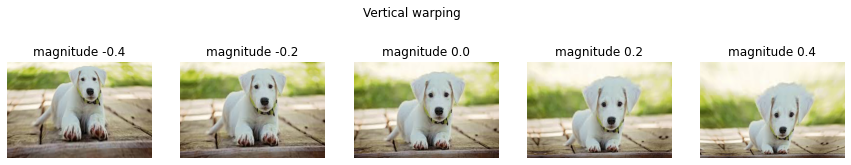

In [34]:
# vertical warping
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_y=scales, draw_x=0.)
y = warp(_batch_ex(5), split_idx=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Vertical warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

Note: vertical warping.


### Horizontal warping


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


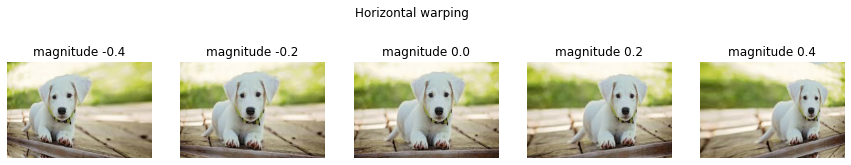

In [35]:
# horizontal warping
warp = Warp(p=1., draw_x=scales, draw_y=0.)
y = warp(_batch_ex(5), split_idx=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Horizontal warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

## Lighting
`brightness`

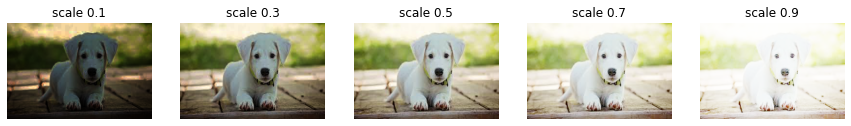

In [36]:
# lighting according to a list of scales
scales = [0.1, 0.3, 0.5, 0.7, 0.9]
y = _batch_ex(5).brightness(draw=scales, p=1.)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

## Contrast
`contrast`

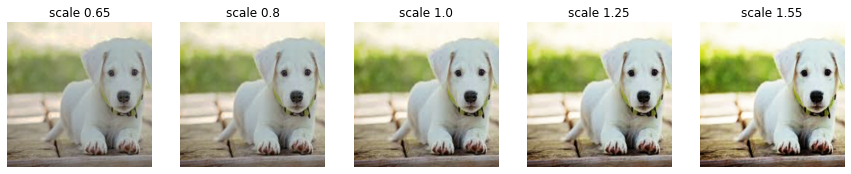

In [ ]:
scales = [0.65, 0.8, 1., 1.25, 1.55]
y = _batch_ex(5).contrast(p=1., draw=scales)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

## Erasing
This variant, designed by Ross Wightman, is applied to either a batch or single image tensor after it has been normalized.

First, you need to normalize an image, then apply a gaussian cutout (adding some "noise") and then denormalize the image.

In [ ]:
# Normalizing an image
nrm = Normalize.from_stats(*imagenet_stats, cuda=False)

In [ ]:
# Replace `areas` of an image with some "noise" 
??cutout_gaussian

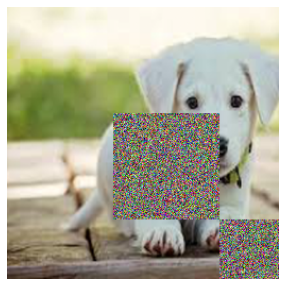

In [ ]:
# applying a gaussian cutout and then denormalize
f = partial(cutout_gaussian, areas=[(100,200,100,200),(200,300,200,300)])
show_image(norm_apply_denorm(timg, f, nrm)[0]);

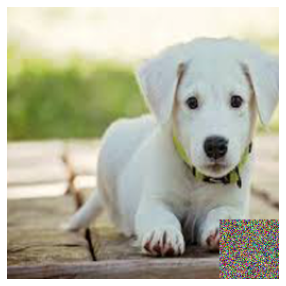

In [ ]:
# applying a gaussian cutout and then denormalize
f = partial(cutout_gaussian, areas=[(50,50,50,50),(200,300,200,300)])
show_image(norm_apply_denorm(timg, f, nrm)[0]);

## Random Erasing
`RandomErasing()`

Randomly selects a rectangle region in an image and randomizes its pixels.

In [ ]:
# Randomly selects a rectangle region in an image and randomizes its pixels."
??RandomErasing

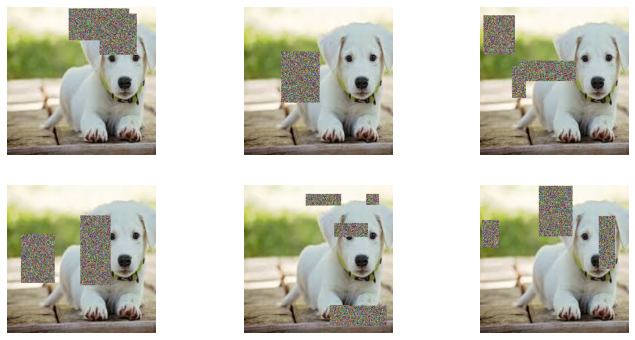

In [ ]:
tfm = RandomErasing(p=1., max_count=6)
_,axs = subplots(2,3, figsize=(12,6))
f = partial(tfm, split_idx=0)
for i,ax in enumerate(axs.flatten()): show_image(norm_apply_denorm(timg, f, nrm)[0], ctx=ax)


# All Together

### Utility - Augmentation Function
Utility func to easily **create a list of flip, rotate, zoom, warp, lighting transforms.**

Random flip (or dihedral if flip_vert=True) with p=0.5 is added when do_flip=True. With p_affine we apply a random rotation of max_rotate degrees, a random zoom between min_zoom and max_zoom and a perspective warping of max_warp. With p_lighting we apply a change in brightness and contrast of max_lighting. Custon xtra_tfms can be added. size, mode and pad_mode will be used for the interpolation. max_rotate,max_lighting,max_warp are multiplied by mult so you can more easily increase or decrease augmentation with a single parameter.

In [37]:
# Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.
??aug_transforms

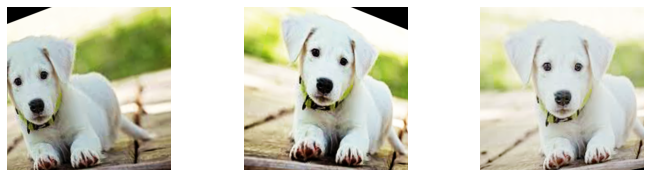

In [40]:
# using a fastai2 image augmentation
tfms = aug_transforms(pad_mode='zeros', mult=2, min_scale=0.5)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(1,3, figsize=(12,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

# Image Segmentation
In digital image processing and computer vision, image segmentation is the process of partitioning a digital image into multiple segments (sets of pixels, also known as image objects). ... Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images.

In [41]:
# Getting a mask segmentation dataset
path = untar_data(URLs.CAMVID_TINY, dest='camvid')
path.ls()

(#3) [Path('camvid/camvid_tiny/codes.txt'),Path('camvid/camvid_tiny/labels'),Path('camvid/camvid_tiny/images')]

In [42]:
# accessing the codes defined for segmentation
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [43]:
# the image file
fns = get_image_files(path/"images")
fns[0]

Path('camvid/camvid_tiny/images/0006R0_f02550.png')

In [44]:
# The segmentation mask file (_P)
(path/"labels").ls()[0]

Path('camvid/camvid_tiny/labels/0016E5_08093_P.png')

NOTE: a mask segmentation dataset set has two files, the image file and its segmentation mask identified by `_P`.

In [47]:
# accessing an image
cam_fn = fns[0]
# accessing a mask file
mask_fn = path/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'
# function to return an image with its mask
def _cam_lbl(fn): return mask_fn

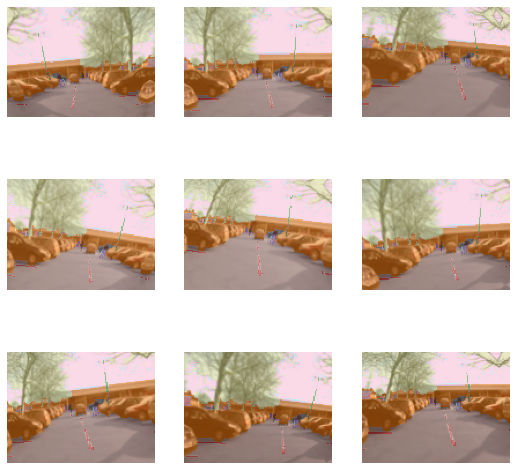

In [48]:
cam_dsrc = Datasets([cam_fn]*10, [PILImage.create, [_cam_lbl, PILMask.create]])
cam_tdl = TfmdDL(cam_dsrc.train, after_item=ToTensor(),
                 after_batch=[IntToFloatTensor(), *aug_transforms()], bs=9)
cam_tdl.show_batch(max_n=9, vmin=1, vmax=30)

NOTE: `after_item` will put the image into a tensor.
`after_batch` will use the fastai augmentation `*aug_transforms`

In [51]:
??show_batch

# Bounding Boxes

In [52]:
# bounding boxes example
coco = untar_data(URLs.COCO_TINY, dest='coco')
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]

def _coco_bb(x):  return TensorBBox.create(bbox[0])
def _coco_lbl(x): return bbox[1]

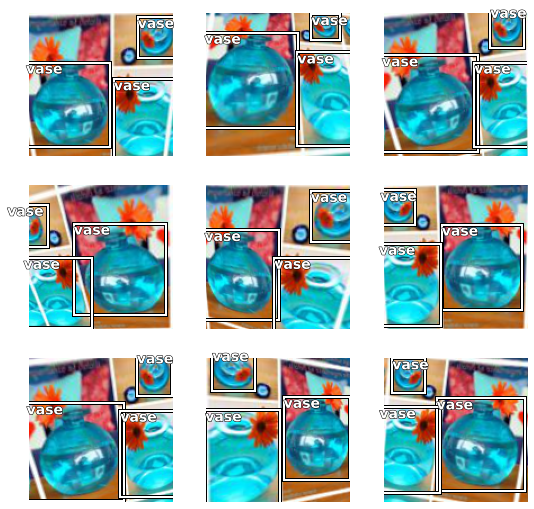

In [53]:
coco_dsrc = Datasets([coco_fn]*10, [PILImage.create, [_coco_bb], [_coco_lbl, MultiCategorize(add_na=True)]], n_inp=1)
coco_tdl = TfmdDL(coco_dsrc, bs=9, after_item=[BBoxLabeler(), PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

coco_tdl.show_batch(max_n=9)

# Image to Tensor

In [54]:
path = untar_data(URLs.MNIST_SAMPLE, dest='/content')

In [55]:
Path.BASE_PATH = path

In [56]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [57]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [58]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [59]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [61]:
# array representation
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [62]:
# tensor representation
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

# Manually going through the pipeline


## Getting an image

In [63]:
# Getting an image and resizing it 
img = PILImage(PILImage.create("/content/images/puppy1.jpeg").resize((600,400)))

In [64]:
img.shape, type(img) 

((400, 600), fastai2.vision.core.PILImage)

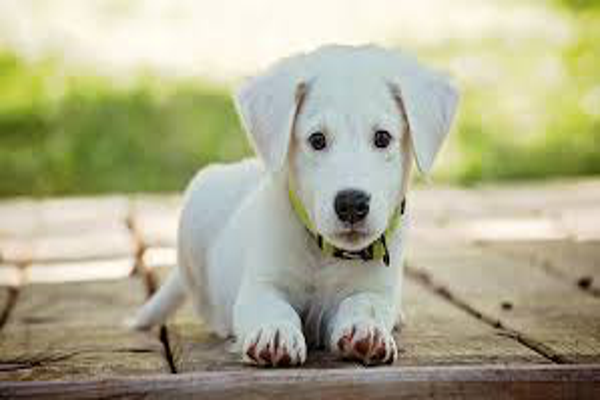

In [65]:
img

## Resizing it
Resizing the image to 256 px

In [66]:
#Resize to 256 using default crop and reflection padding
r = Resize(256, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection)
img = r(img)
img.shape, type(img)

((256, 256), fastai2.vision.core.PILImage)

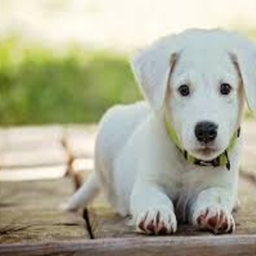

In [ ]:
img

## Cropping the image

In [ ]:
# Crop
crp = CropPad(256)
img = r(crp(img))
img.shape, type(img)

((256, 256), fastai2.vision.core.PILImage)

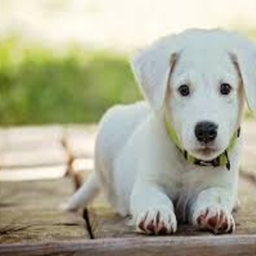

In [ ]:
img

# Converting a PIL Image to a Tensor

In [69]:
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
timg.shape, type(timg)

(torch.Size([3, 256, 256]), fastai2.torch_core.TensorImage)

In [68]:
h = TensorImage(timg[None].expand(3, *timg.shape).clone())
h.shape, type(h)

(torch.Size([3, 3, 400, 600]), fastai2.torch_core.TensorImage)

NOTE: batch=3, channels=3 (RGB), size=256x256 px

## Flipping an image

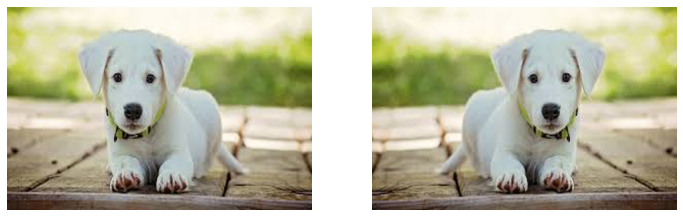

In [70]:
#if do_flip=true and flip-vert=false = Flip
fli = Flip(p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y = fli(h)
    show_image(y[0], ctx=ax, cmap='Greys')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


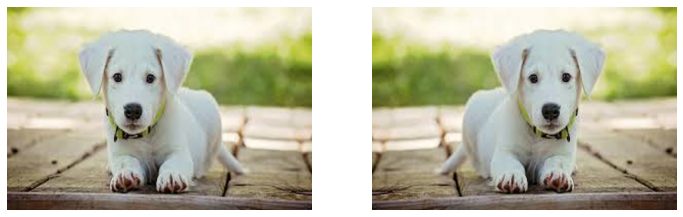

In [71]:
#if do_flp=true and flip_vert=true = dihyderal
dih = Dihedral(p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y1 = dih(h)
    show_image(y1[0], ctx=ax)

## Rotation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


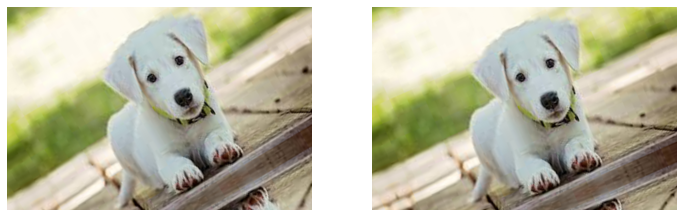

In [72]:
#Rotate 
rot = Rotate(max_deg=45, p=1.)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y2 = rot(h)
    show_image(y2[0], ctx=ax)


## Zoom

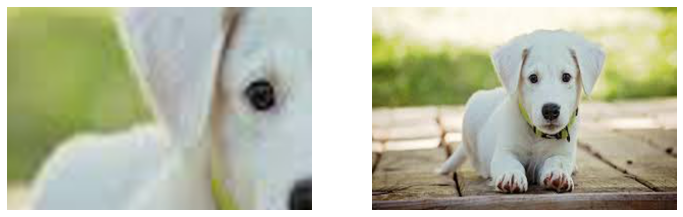

In [73]:
# Zoom
zoo = Zoom(max_zoom=4.1, p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y3 = zoo(h)
    show_image(y3[0], ctx=ax)

## Warp

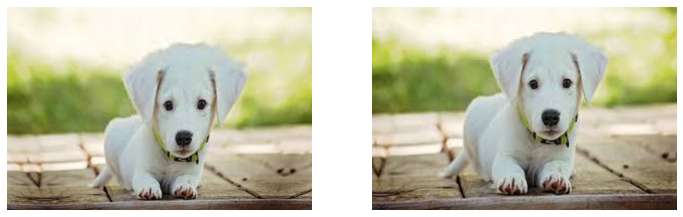

In [74]:
# Warp
war = Warp(magnitude=0.7, p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y4 = war(h)
    show_image(y4[0], ctx=ax)

## Brightness

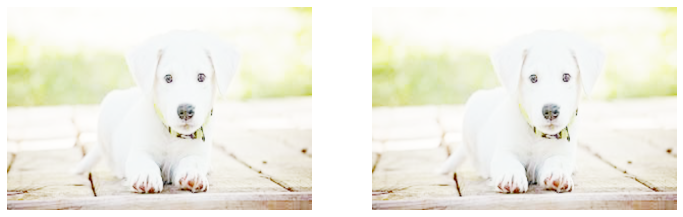

In [75]:
#Brightness
bri = h.brightness(draw=0.9, p=1.)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y5 = bri
    show_image(y5[0], ctx=ax)

## Contrast

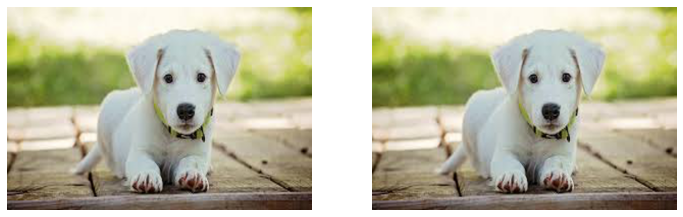

In [76]:
#Contrast
con = h.contrast(draw=1.9, p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y6 = con
    show_image(y6[0], ctx=ax)

## All together

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


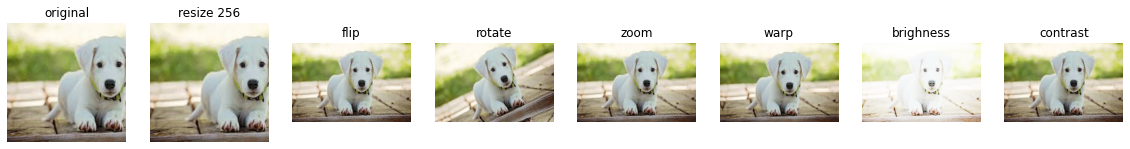

In [77]:

_,axs = plt.subplots(1,8, figsize=(20,9))
for i,ax in enumerate(axs.flatten()):
    y7 = y1 + y4
    show_image(img, ctx=axs[0], title='original')
    show_image(img, ctx=axs[1], title='resize 256')
    show_image(y[0], ctx=axs[2], title='flip')
    show_image(y2[0], ctx=axs[3], title='rotate')
    show_image(y3[0], ctx=axs[4], title='zoom')
    show_image(y4[0], ctx=axs[5], title='warp')
    show_image(y5[0], ctx=axs[6], title='brighness')
    show_image(y6[0], ctx=axs[7], title='contrast')

# Using a batch


In [78]:
source = untar_data(URLs.PETS, dest='content/Pets')

In [79]:
source

Path('content/Pets/oxford-iiit-pet')

In [80]:
#High-level fastai2 API example
testblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=[Resize(256)],
                 batch_tfms=[*aug_transforms(xtra_tfms=None)])
test_dls = testblock.dataloaders(source/'images')

In [81]:
test_dls.show_batch(max_n=6, nrows=1, ncols=6)

## Revealing the fastai2 pipeline process

The fastai2 pipeline process for batch transformations does the following: 
- convert integers to float tensors
- apply all the affine transformations
- followed by the lighting transformations

The order is important in order to maintain a number of key aspects:
- Maintain image quality
- Reduce computations
- Improve efficiency

To check the order of how augmentations are conducted we can call `after_item` and `after_batch`.

In [82]:
# dataloader - after item
test_dls.after_item

Pipeline: Resize -> ToTensor

NOTE:  After batch augmentation. In this case images are:

- resized to sizes of equal length, in this case 256 and then

- converted the image into a channel X *height* X *weigth* tensor

In [83]:
# dataloader - after batch
test_dls.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm

In [84]:
#Helper for viewing single images
def repeat_one(source, n=128):
    """Single image helper for displaying batch"""
    return [get_image_files(source)[1]]*n

In [85]:
#mid-level API example 
tfms = [[PILImage.create], [using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), Categorize]]
item_tfms = [ToTensor(), Resize(256)]
splitter=RandomSplitter(seed=42)
# adding additional transformations xtra_tfms
after_b = [IntToFloatTensor(), *aug_transforms(xtra_tfms=RandomResizedCrop(256), min_scale=0.9)]

dsets = Datasets(repeat_one(source/'images'), tfms=tfms)
dls = dsets.dataloaders(after_item=item_tfms, after_batch=after_b, bs=32, num_workers=0, splits=splitter)

In [86]:
dls.after_batch

Pipeline: RandomResizedCrop -> IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm

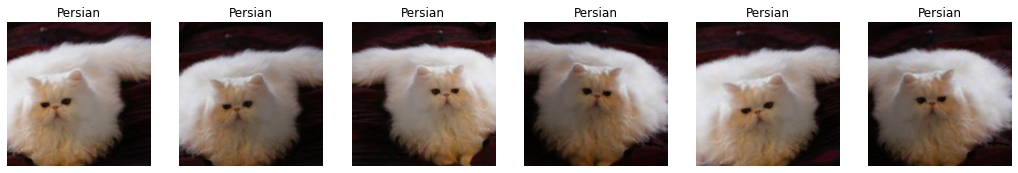

In [ ]:
dls.show_batch(max_n=6, nrows=1, ncols=6)

NOTE: it shows the different transformations that has been applied to one image.

In [87]:
#create 1 batch
x,y = dls.one_batch()

CPU times: user 41.7 ms, sys: 18.8 ms, total: 60.5 ms
Wall time: 60.5 ms


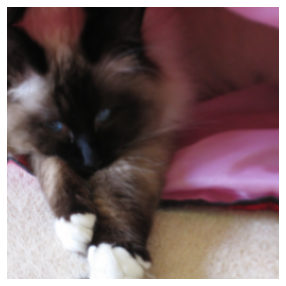

In [92]:
%%time
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=256)
x1 = x1.brightness(max_lighting=0.2, p=1.)
x1 = x1.zoom(max_zoom=1.1, p=0.5)
x1 = x1.warp(magnitude=0.2, p=0.5)

_,axs = subplots(1, 1, figsize=(5,5))
TensorImage(x1[0]).show(ctx=axs[0])

CPU times: user 36.8 ms, sys: 8.93 ms, total: 45.7 ms
Wall time: 45.8 ms


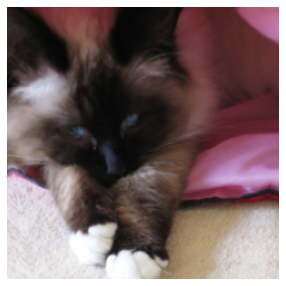

In [93]:
%%time
tfms = setup_aug_tfms([Brightness(max_lighting=0.2, p=1.,),
                       CropPad(size=256),
                       Zoom(max_zoom=1.1, p=0.5),
                       Warp(magnitude=0.2, p=0.5)
                      ])
x = Pipeline(tfms)(x)
_,axs = subplots(1, 1, figsize=(5,5))
TensorImage(x[0]).show(ctx=axs[0])

In [94]:
# defining an image composition
def image_comp():
    x,y = dls.one_batch()
    tfms = setup_aug_tfms([Brightness(max_lighting=0.3, p=1.,),
                       Resize(size=256),
                       Zoom(max_zoom=1.1, p=1.),
                       Warp(magnitude=0.2, p=1.)
                      ])
    x = Pipeline(tfms)(x)

    x1 = TensorImage(x.clone())
    x1 = x1.affine_coord(sz=256)
    x1 = x1.brightness(max_lighting=0.3, p=1.)
    x1 = x1.zoom(max_zoom=1.1, p=1.)
    x1 = x1.warp(magnitude=0.2, p=1.)

    _,axs = subplots(1, 2, figsize=(20,20))
    TensorImage(x[0]).show(ctx=axs[0], title='fastai')
    TensorImage(x1[0]).show(ctx=axs[1], title='other')

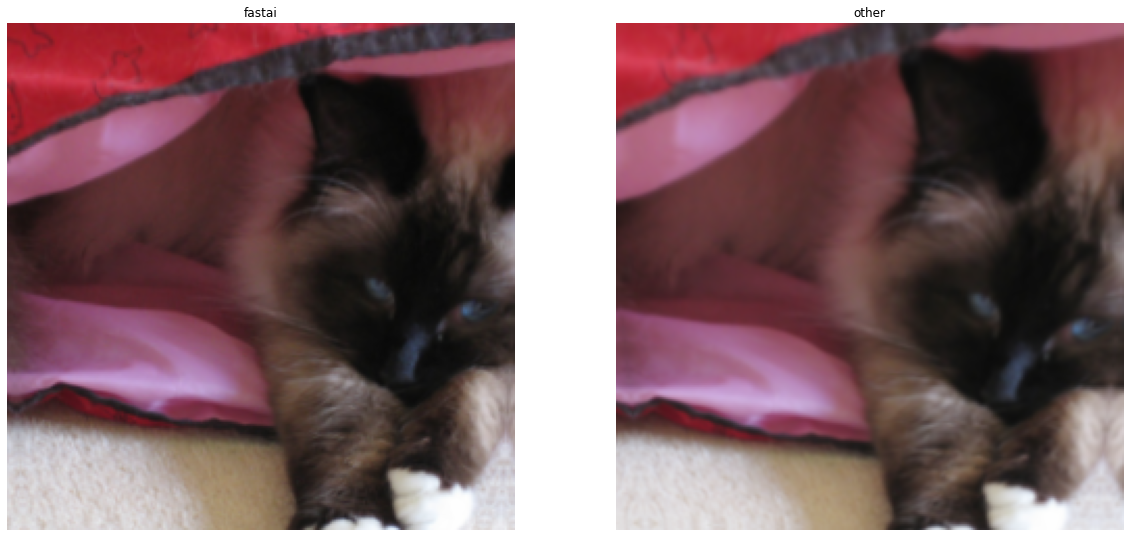

In [95]:
image_comp()

NOTE:  You can definately see differences between the two pictures, the 'fastai' image is more clearer compared to the 'other' image. How about some other examples

In [96]:
#Include multiple transforms
tfms = [[PILImage.create], [using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), Categorize]]
item_tfms = [ToTensor(), Resize(296)]
splitter=RandomSplitter(seed=42)
xtra_tfms = [Rotate(max_deg=45, p=1.),
            RandomErasing(p=1., max_count=10, min_aspect=0.5, sl=0.2, sh=0.2),
            RandomResizedCrop(p=1., size=256),
            Brightness(max_lighting=0.2, p=1.),
            CropPad(size=256),
            Zoom(max_zoom=2.1, p=0.5),
            Warp(magnitude=0.2, p=1.0)
            ]
after_b = [IntToFloatTensor(), *aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=0., 
           max_zoom=1.1, max_lighting=0.,max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=xtra_tfms, size=256,
           mode='bilinear', pad_mode=PadMode.Reflection, align_corners=True, batch=False, min_scale=0.9)]

mdsets = Datasets(repeat_one(source/'images'), tfms=tfms)
mdls = mdsets.dataloaders(after_item=item_tfms, after_batch=after_b, bs=32, num_workers=0, splits=splitter)

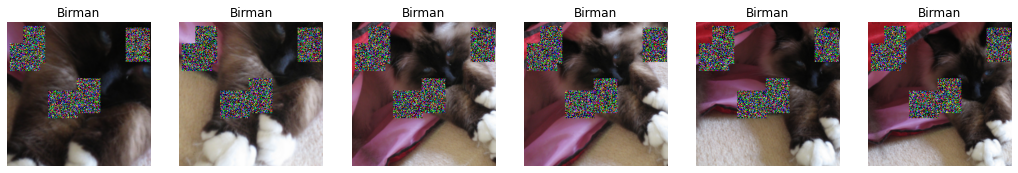

In [97]:
mdls.show_batch(max_n=6, nrows=1, ncols=6)

In [ ]:
mdls.after_batch

In [98]:
RandomResizedCrop.order, CropPad.order, IntToFloatTensor.order, AffineCoordTfm.order, RandomResizedCropGPU.order, RandomErasing.order

(0, 0, 10, 30, 30, 100)

NOTE:  You can force the order by implicity specifying the order of a transform by stating the order within a transform class.  However if you add RandomResizedCrop as well as a min_scale value the pipeline now looks like this:

NOTE: if you use RandomResizedCrop with no min_scale value the pipeline is now:

In [99]:
mdls.after_batch

Pipeline: RandomResizedCrop -> CropPad -> IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> RandomErasing